# Sentiment analysis using GPT2 and Bert

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch import nn
from torch.optim import Adam
from transformers import GPT2Model, GPT2Tokenizer
from transformers import BertModel, BertTokenizer
from torch.utils.data import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, cohen_kappa_score, confusion_matrix, classification_report
import sklearn

from sklearn.model_selection import train_test_split

In [2]:
train_df_read = pd.read_csv('data\\Twitter_Data.csv')

In [3]:
train_df_read.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [4]:
train_df_read.isna().sum()

clean_text    4
category      7
dtype: int64

In [6]:
train_df_read.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [7]:
train_df_read = train_df_read.rename(columns={'clean_text': 'content',  'category': 'label'})

In [8]:
train_df_read.isna().sum()

content    4
label      7
dtype: int64

### Data Visualization

label
 1.0    72250
 0.0    55213
-1.0    35510
Name: count, dtype: int64


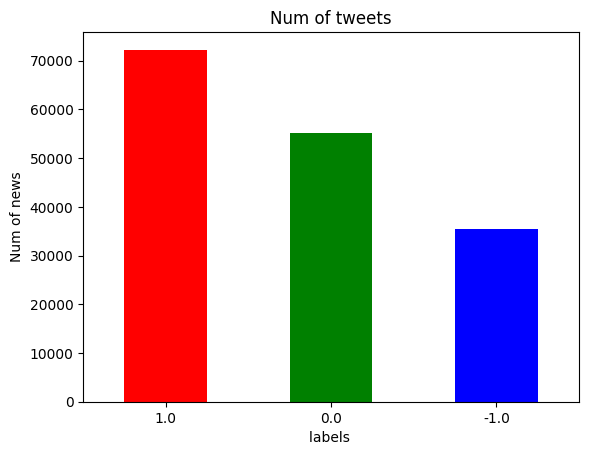

In [9]:
labels_num = train_df_read['label'].value_counts()
print(labels_num)
labels_num.plot(kind='bar', color=['red', 'green', 'blue'])


plt.title('Num of tweets')
plt.xlabel('labels ')
plt.ylabel('Num of news')
plt.xticks(rotation=0)
plt.show()

### Helper functions

In [10]:
def task_df(train_df):
    task_df = pd.DataFrame()
    task_df['content'] = train_df['content']
    task_df["label"] = train_df['label'].replace({0: 'negative', 1: 'neutral', 2: 'positive'})
    return task_df

In [11]:
def plot_res(accuracy, loss):
    plt.figure(figsize=(15, 15))
    
    # Accuracy plot
    plt.subplot(3, 3, 1)
    plt.plot(accuracy[0], label='accuracy')
    plt.plot(accuracy[1], label='val_accuracy')
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')

    # Loss plot
    plt.subplot(3, 3, 2)
    plt.plot(loss[0], label='loss')
    plt.plot(loss[1], label='val_loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.show()

In [12]:
def plot_res_predicted(y_pred, y_labels):
    print("accuracy_score is  {:.2f}%".format(sklearn.metrics.accuracy_score(y_labels, y_pred)*100))
    print("balanced_accuracy_score is  {:.2f}%".format(sklearn.metrics.balanced_accuracy_score(y_labels, y_pred)*100))
    print("f1_score is  {:.2f}%".format(sklearn.metrics.f1_score(y_labels, y_pred, average='weighted')*100))
    print("recall_score is  {:.2f}%".format(sklearn.metrics.recall_score(y_labels, y_pred, average='weighted')*100))
    print("precision_score is  {:.2f}%".format(sklearn.metrics.precision_score(y_labels, y_pred, average='weighted')*100))

In [13]:
def plot_confusion_matrix(y_labels, y_pred):
    conf_matrix = confusion_matrix(y_labels, y_pred)
    ax = plt.subplot()
    sns.heatmap(conf_matrix, annot = True, fmt = 'g', ax = ax, cmap = 'Blues')
    # labels, title and ticks
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('Confusion Matrix')
    plt.show()


In [14]:
labels = {
    "negative": 0,
    "neutral": 1,
    "positive": 2,
    }

### Training dataset

In [15]:
def get_tokinazer(type_tokinazer):
    if type_tokinazer == 'BERT':
        tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
    elif type_tokinazer == 'GPT2':
        tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
        tokenizer.padding_side = "left"
        tokenizer.pad_token = tokenizer.eos_token
    return tokenizer

In [16]:
def get_labels(train_df):
    train_labels = np.zeros((len(train_df), 3))
    train_labels[:,0] = train_df['label'] == 'negative'
    train_labels[:,1] = train_df['label'] == 'neutral'
    train_labels[:,2] = train_df['label'] == 'positive'
    return train_labels

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer):
        self.labels = [labels[label] for label in df['label']]
        self.texts = [tokenizer(text, padding='max_length', max_length=128, truncation=True, return_tensors="pt") for text in df['content']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])
        return batch_texts, batch_labels

## Models

### 1. Bert

In [18]:
class SimpleBert(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, bert_model_name:str):
        super(SimpleBert,self).__init__()
        self.bertmodel = BertModel.from_pretrained(bert_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes, device='cuda')

    def forward(self, input_id, mask):
        bert_out, _ = self.bertmodel(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = bert_out.shape[0]
        linear_output = self.fc1(bert_out.view(batch_size,-1))
        return linear_output

### 2. GPT2

In [19]:
class SimpleGPT2(nn.Module):
    def __init__(self, hidden_size: int, num_classes:int ,max_seq_len:int, gpt_model_name:str):
        super(SimpleGPT2,self).__init__()
        self.gpt2model = GPT2Model.from_pretrained(gpt_model_name)
        self.fc1 = nn.Linear(hidden_size*max_seq_len, num_classes, device='cuda')

    def forward(self, input_id, mask):
        gpt_out, _ = self.gpt2model(input_ids=input_id, attention_mask=mask, return_dict=False)
        batch_size = gpt_out.shape[0]
        linear_output = self.fc1(gpt_out.view(batch_size,-1))
        return linear_output

### Train func

In [20]:
def train(model, train_data, val_data, learning_rate, epochs, tokenizer):
    train = Dataset(train_data, tokenizer)
    test = Dataset(val_data, tokenizer)

    train_dataloader = DataLoader(train, batch_size=32, shuffle=True)
    test_dataloader = DataLoader(test, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=learning_rate)

    accuracy_train, accuracy_test = [], []
    loss_train, loss_test = [], []

    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):
        total_acc_train = 0
        total_loss_train = 0

        for train_input, train_label in tqdm(train_dataloader):
            train_label = train_label.to(device)
            mask = train_input['attention_mask'].to(device)
            input_id = train_input["input_ids"].squeeze(1).to(device)

            model.zero_grad()

            output = model(input_id, mask)

            batch_loss = criterion(output, train_label)
            total_loss_train += batch_loss.item()

            acc = (output.argmax(dim=1)==train_label).sum().item()
            total_acc_train += acc

            batch_loss.backward()
            optimizer.step()

        total_acc_val = 0
        total_loss_val = 0

        with torch.no_grad():

            for test_input, test_label in test_dataloader:
                test_label = test_label.to(device)
                mask = test_input['attention_mask'].to(device)
                input_id = test_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)

                batch_loss = criterion(output, test_label)
                total_loss_val += batch_loss.item()

                acc = (output.argmax(dim=1)==test_label).sum().item()
                total_acc_val += acc

            print(f"Epochs: {epoch_num + 1} | Train Loss: {total_loss_train/len(train_data): .3f} \
            | Train Accuracy: {total_acc_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / len(val_data): .3f} \
            | Val Accuracy: {total_acc_val / len(val_data): .3f}")

            accuracy_train.append(total_acc_train / len(train_data))
            accuracy_test.append(total_acc_val / len(val_data))
            loss_train.append(total_loss_train/len(train_data))
            loss_test.append(total_loss_val / len(val_data))
    return (accuracy_train, accuracy_test), (loss_train, loss_test)

In [21]:
def evaluate(model, test_data):
    print()
    if type(model) == SimpleGPT2:
        token = get_tokinazer('GPT2')
    else:
        token = get_tokinazer('BERT')
    test = Dataset(test_data, token)

    test_dataloader = DataLoader(test, batch_size=32)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()


    # Tracking variables
    predictions_labels = []
    true_labels = []

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

            test_label = test_label.to(device)
            mask = test_input['attention_mask'].to(device)
            input_id = test_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask)

            acc = (output.argmax(dim=1) == test_label).sum().item()
            total_acc_test += acc

            # add original labels
            true_labels += test_label.cpu().numpy().flatten().tolist()
            # get predicitons to list
            predictions_labels += output.argmax(dim=1).cpu().numpy().flatten().tolist()
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')
    return true_labels, predictions_labels


### Training

In [22]:
models = ['GPT2', 'BERT']

train_df, test_df = train_test_split(train_df_read, test_size=0.1, random_state=42)

train_df = task_df(train_df)
test_df =  task_df(test_df)

train_labels = get_labels(train_df)
test_labels = get_labels(test_df)

for model_name in models:
    if model_name == 'GPT2':
        token = get_tokinazer(model_name)
        model = SimpleGPT2(hidden_size=768, num_classes=3, max_seq_len=128, gpt_model_name="gpt2")
    elif model_name == 'BERT':
        token = get_tokinazer(model_name)
        model = SimpleBert(hidden_size=768, num_classes=3, max_seq_len=128, bert_model_name="bert-base-cased")
    print(type(token))
    print(type(model))
    epochs = 3
    lr = 0.0001
    accuracy, loss = train(model, train_df, test_df, lr, epochs, token)
    true_labels, pred_labels = evaluate(model, test_df)
    plot_res(accuracy, loss)
    plot_res_predicted(pred_labels, true_labels)
    plot_confusion_matrix(true_labels, pred_labels)
    print(classification_report(true_labels, pred_labels))
    torch.save(model.state_dict(), f'modelstore/{model_name}.pt')